In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage.feature
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
%matplotlib inline

Using TensorFlow backend.


In [2]:
r = 0.4     #scale down
width = 100 #patch size 

In [3]:
%pwd

'C:\\Users\\604572\\Desktop\\Sea Lion Counting\\exploratory\\Mask_RCNN'

In [30]:
def GetData(filename):
    # read the Train and Train Dotted images
    image_1 = cv2.imread("../../data/TrainSmall2/TrainDotted/" + filename)
    image_2 = cv2.imread("../../data/TrainSmall2/Train/" + filename)
    img1 = cv2.GaussianBlur(image_1,(5,5),0)

    # absolute difference between Train and Train Dotted
    image_3 = cv2.absdiff(image_1,image_2)
    mask_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
    mask_1[mask_1 < 50] = 0
    mask_1[mask_1 > 0] = 255
    image_4 = cv2.bitwise_or(image_3, image_3, mask=mask_1)

    # convert to grayscale to be accepted by skimage.feature.blob_log
    image_6 = np.max(image_4,axis=2)

    # detect blobs
    blobs = skimage.feature.blob_log(image_6, min_sigma=3, max_sigma=7, num_sigma=1, threshold=0.05)

    h,w,d = image_2.shape

    res=np.zeros((int((w*r)//width)+1,int((h*r)//width)+1,5), dtype='int16')

    for blob in blobs:
        # get the coordinates for each blob
        y, x, s = blob
        #print(blob)
        # get the color of the pixel from Train Dotted in the center of the blob
        b,g,R = img1[int(y)][int(x)][:]
        x1 = int((x*r)//width)
        y1 = int((y*r)//width)
        # decision tree to pick the class of the blob by looking at the color in Train Dotted
        if R > 225 and b < 25 and g < 25: # RED
            res[x1,y1,0]+=1
        elif R > 225 and b > 225 and g < 25: # MAGENTA
            res[x1,y1,1]+=1
        elif R < 75 and b < 50 and 150 < g < 200: # GREEN
            res[x1,y1,4]+=1
        elif R < 75 and  150 < b < 200 and g < 75: # BLUE
            res[x1,y1,3]+=1
        elif 60 < R < 120 and b < 50 and g < 75:  # BROWN
            res[x1,y1,2]+=1

    ma = cv2.cvtColor((1*(np.sum(image_1, axis=2)>20)).astype('uint8'), cv2.COLOR_GRAY2BGR)
    img = cv2.resize(image_2 * ma, (int(w*r),int(h*r)))
    h1,w1,d = img.shape

    trainX = []
    trainY = []

    for i in range(int(w1//width)):
        for j in range(int(h1//width)):
            trainY.append(res[i,j,:])
            trainX.append(img[j*width:j*width+width,i*width:i*width+width,:])
            #print(f'img[{j}*{width}:{j}*{width}+{width},{i}*{width}:{i}*{width}+{width},:]')
            #print(f'img[{j*width}:{j*width+width},{i*width}:{i*width+width},:]')

    return trainX, trainY
    #return np.array(trainX), np.array(trainY)

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [32]:
trainX = []
trainY = []
for i in range(41,51):
    data = GetData(f'{i}.jpg')
    trainX.extend(data[0])
    trainY.extend(data[1])
trainX = np.array(trainX)
trainY = np.array(trainY)
print(trainX.shape, trainY.shape)

(2653, 100, 100, 3) (2653, 5)


In [33]:
#trainX, trainY = GetData("41.jpg")

np.random.seed(1004)
randomize = np.arange(len(trainX))
np.random.shuffle(randomize)
trainX = trainX[randomize]
trainY = trainY[randomize]

n_train = int(len(trainX) * 0.7)
testX = trainX[n_train:]
testY = trainY[n_train:]
trainX = trainX[:n_train]
trainY = trainY[:n_train]

print(trainY.shape, trainY[0])
print(testY.shape, testY[0])

(1857, 5) [0 0 0 0 0]
(796, 5) [0 0 0 0 0]


In [15]:
trainX.shape

(172, 100, 100, 3)

In [12]:
trainY

array([[ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 1,  0, 10,  5,  2],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 1,  0,  3,  1,  3],
       [ 0,  0,  0,  0,  0],
       [ 1,  0, 10,  1,  6],
       [ 1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  6,  1,  2],
       [ 0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0],
       [ 1,  0,  4,  0,  2],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0],
       [ 0,  0,  2,  1,  4],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  3,  0,  5],
       [ 0,  0,  0,  0,  0],
       [ 0,  0

ValueError: num must be 1 <= num <= 170, not 171

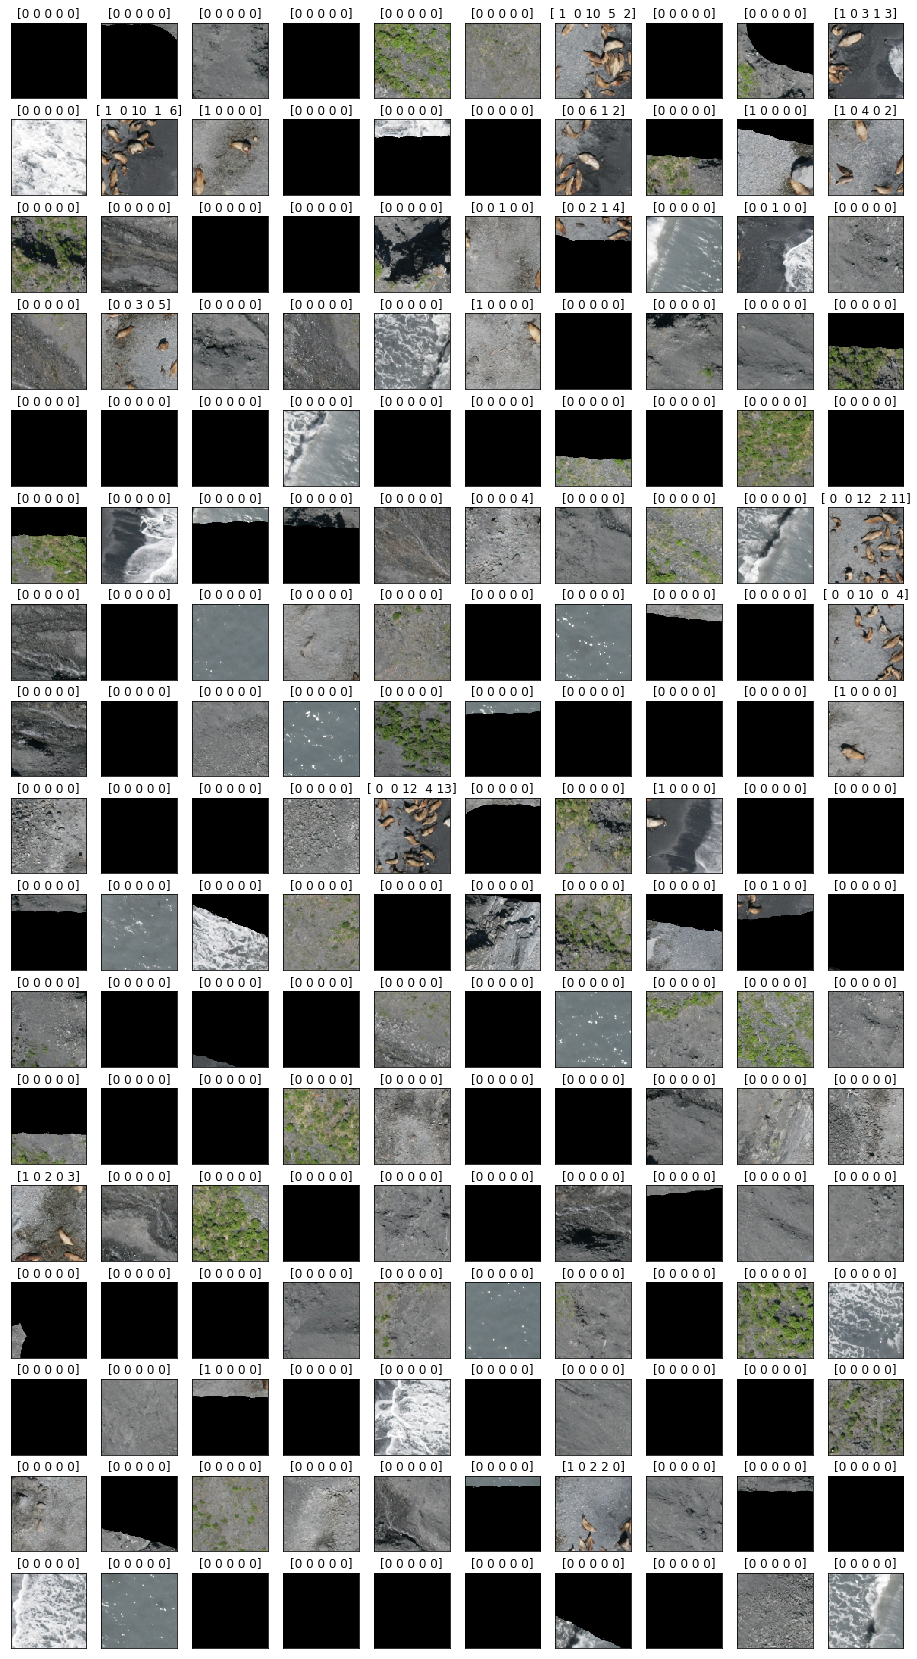

In [23]:
fig = plt.figure(figsize=(16,30))
for i in range(1,trainX.shape[0]):
    ax = fig.add_subplot(trainX.shape[0]/10,10,i)
    ax.title.set_text(trainY[i])
    plt.xticks([]), plt.yticks([])
    plt.imshow(cv2.cvtColor(trainX[i], cv2.COLOR_BGR2RGB))
#print(trainY[:4])